In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)

        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layerout = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=1)

        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 

        h_temp = self.activation(self.layer_3(h))
        h_temp = self.activation(self.layer_4(h_temp))
        h = h_temp + h
        
        z_out = self.layerout(h) 
        return z_out

In [3]:
N = 2000 # number of samples
T = 800  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 8.0 # time horizon
# dt = tf/T # time step

n_sigma = 0.3 # noise level

# A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [4]:
y = torch.tensor([[0.0],[0.0]])
x_0 = torch.tensor([[torch.pi],[0.0]])

In [5]:
t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid shape (T,1)

In [6]:
U_d = torch.zeros(T,m) # control sequence
# A_lin = torch.tensor([[0.0, 1.0],[-1.0, -0.01]])
# Q = torch.tensor([[10.0, 0.0],[0.0, 1.0]])
# R = torch.tensor([[1.0]])
# P = sp.linalg.solve_continuous_are(A_lin.numpy(), B.numpy(), Q.numpy(), R.numpy())
# K = (torch.linalg.inv(R) @ B.T @ P).to(torch.float32)*0

In [7]:
dt = t[1] - t[0]
# X_forward = torch.zeros((T, n))
# X_forward[0,:] = x_0.squeeze(-1)
# for i in range(1, T):
#     # print(i)
#     U_d[i-1,:] = -K @ (X_forward[i-1,:]-y.squeeze(-1)).unsqueeze(-1)
#     df1 = X_forward[i-1,1]
#     df2 = torch.sin(X_forward[i-1,0]) - 0.01*X_forward[i-1,1] 
#     df = torch.stack([df1,df2],dim=0)
#     X_forward[i,:] = (df.T + B @ U_d[i-1,:]) * dt + X_forward[i-1,:]

# plt.figure()
# plt.plot(X_forward[:,0], X_forward[:,1])
# plt.show()

In [8]:
### Generate backward data
X_backward = torch.zeros((T, N, n))
X_backward[-1,:,:] = y.repeat(N,1).reshape(N,n)
for i in range(T-1, 0, -1):
    # print(i)
    df1 = X_backward[i,:,1]
    df2 = torch.sin(X_backward[i,:,0]) - 0.01 * X_backward[i,:,1]
    df = torch.stack((df1, df2), dim=1)
    # print(df.shape)
    dX = (df.T  + B @ U_d[i-1,:].repeat(N,1).T).T * dt + (B @ (n_sigma * torch.randn(N,1)*np.sqrt(dt)).T).T
    X_backward[i-1,:,:] = X_backward[i,:,:] - dX

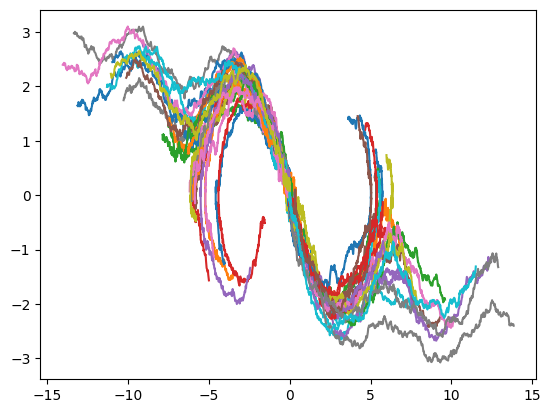

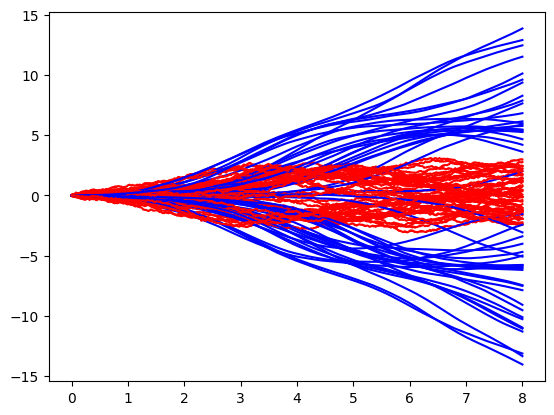

In [9]:
plt.figure()
for i in range(50):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1])
plt.show()

plt.figure()
for i in range(50):
    plt.plot(tf-t, X_backward[:,i,0], color='b')
    plt.plot(tf-t, X_backward[:,i,1], color='r')
plt.show()

# plt.figure()
# plt.plot(X_backward[:,:,0].mean(axis=1), X_backward[:,:,1].mean(axis=1))
# plt.show()

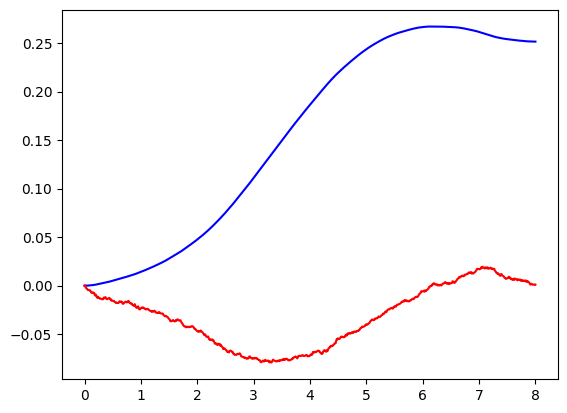

In [10]:
plt.figure()
plt.plot(tf-t,X_backward[:,:,0].mean(axis=1), color='b')
plt.plot(tf-t,X_backward[:,:,1].mean(axis=1), color='r')
plt.show()

In [11]:
def jacobian(y: torch.Tensor, x: torch.Tensor, need_higher_grad=True) -> torch.Tensor:
    (Jac,) = torch.autograd.grad(
        outputs=(y.flatten(),),
        inputs=(x,),
        grad_outputs=(torch.eye(torch.numel(y)),),
        create_graph=need_higher_grad,
        allow_unused=True,
        is_grads_batched=True
    )
    if Jac is None:
        Jac = torch.zeros(size=(y.shape + x.shape))
    else:
        Jac.reshape(shape=(y.shape + x.shape))
    return Jac

In [12]:
def batched_jacobian(batched_y:torch.Tensor,batched_x:torch.Tensor,need_higher_grad = True) -> torch.Tensor:
    sumed_y = batched_y.sum(dim = 0) # y_shape
    J = jacobian(sumed_y,batched_x,need_higher_grad) # y_shape x N x x_shape
    
    dims = list(range(J.dim()))
    dims[0],dims[sumed_y.dim()] = dims[sumed_y.dim()],dims[0]
    J = J.permute(dims = dims) # N x y_shape x x_shape
    return J

In [13]:
x = torch.tensor([[1.0],[2.0]], requires_grad=True)
y = torch.stack((x[0]**2 + x[1]**2, x[0]*x[1]))
jac = jacobian(y, x)
jac[:,:,0]

tensor([[2., 4.],
        [2., 1.]], grad_fn=<SelectBackward0>)

In [14]:
x = torch.tensor([[1.0,2.0],[3.0,4.0],[5.0,6.0],[7.0,8.0],[9.0,10.0]], requires_grad=True)
y = torch.stack((x[:,0]**2 + x[:,1]**2, x[:,0]*x[:,1]),dim=1)
Bjac = batched_jacobian(y, x)
Bjac

tensor([[[ 2.,  4.],
         [ 2.,  1.]],

        [[ 6.,  8.],
         [ 4.,  3.]],

        [[10., 12.],
         [ 6.,  5.]],

        [[14., 16.],
         [ 8.,  7.]],

        [[18., 20.],
         [10.,  9.]]], grad_fn=<PermuteBackward0>)

In [15]:
temp_test = torch.einsum('ij,tjk->tik', B@B.T, Bjac)
BatchTrace_test = temp_test.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
BatchTrace_test

tensor([[1.],
        [3.],
        [5.],
        [7.],
        [9.]], grad_fn=<SumBackward1>)

In [16]:
### learning k(x,t)###
t_N = t.repeat(1,N).reshape(T,N,1)
ITERS = 20000
BATCH_SIZE = 32
LR = 1e-3

k = score_nn(n,16)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=500, gamma=0.95)

losses = []
for i in range(ITERS):
    # print(i)
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_backward[:,idx,:]
    X_train = X_train.view(-1, n)
    t_train = t_N[:,idx,:]  
    t_train = t_train.view(-1, 1)
    X_train.requires_grad = True
    k_value = k.forward(X_train, t_train) 
    # print(k_value.shape)
    gk = k_value @ B.T # shape (T*B, n)
    # gk = gk.unsqueeze(1) # shape (T*B, 1, n)
    batch_norm = torch.einsum('tij,tjk->tik', gk.unsqueeze(1), gk.unsqueeze(2)).squeeze(-1) # shape (T*B,1)
    # loss = score_norm

    batch_jac = batched_jacobian(gk, X_train)
    temp = torch.einsum('ij,tjk->tik', B@B.T, batch_jac)
    batch_trace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
    loss = (batch_norm + batch_trace).sum()/BATCH_SIZE/T
    

    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%1000==0:
        k_value = k.forward(X_train, t_train) 
        gk = k_value @ B.T
        score_norm = torch.sum(gk**2)/BATCH_SIZE/T
        loss = score_norm
        
        BatchJac = batched_jacobian(gk, X_train)
        temp = torch.einsum('ij,tjk->tik', B@B.T, BatchJac)
        BatchTrace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
        loss = loss + BatchTrace.sum()/BATCH_SIZE/T
        losses.append(loss.item())

        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 1000/20000, loss = -3.755739927292
Iteration: 2000/20000, loss = -3.854715347290
Iteration: 3000/20000, loss = -4.900061607361
Iteration: 4000/20000, loss = -5.203328132629
Iteration: 5000/20000, loss = -5.329113006592
Iteration: 6000/20000, loss = -4.938060760498
Iteration: 7000/20000, loss = -5.660441875458
Iteration: 8000/20000, loss = -5.987560272217
Iteration: 9000/20000, loss = -5.264471054077
Iteration: 10000/20000, loss = -5.503036499023
Iteration: 11000/20000, loss = -5.847609519958
Iteration: 12000/20000, loss = -5.827288627625
Iteration: 13000/20000, loss = -5.523713588715
Iteration: 14000/20000, loss = -6.616682529449
Iteration: 15000/20000, loss = -6.113879203796
Iteration: 16000/20000, loss = -6.241851806641
Iteration: 17000/20000, loss = -5.402945041656
Iteration: 18000/20000, loss = -5.993822097778
Iteration: 19000/20000, loss = -6.073988914490
Iteration: 20000/20000, loss = -6.434609413147


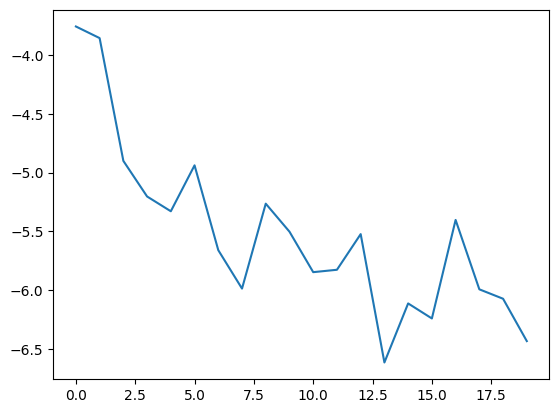

In [17]:
plt.figure()
plt.plot(losses)
plt.show()


In [18]:
# exp1tAtrans = generate_expAt(A.T, 1-t)
# phi1t = generate_phit(1-t, n)
# exp1tA = generate_expAt(A, 1-t)
# expt1A = generate_expAt(A, t-1)


In [19]:
W_forward = torch.zeros((T, N, 1))
for i in range(T):
    W_forward[i,:,:] = torch.randn(N,1)*np.sqrt(dt)

In [35]:
k_record = torch.zeros((T, N, 1))
# u_s_record = torch.zeros((T, N, 1))
u1_record = torch.zeros((T, N, 1))
# u2_record = torch.zeros((T, N, 1))
# u3_record = torch.zeros((T, N, 1))
X_pred = torch.zeros((T, N, n))
X_pred[0,:,:] = -1*x_0.repeat(1,N).T
# X_pred2 = torch.zeros((T, N, n))
# X_pred2[0,:,:] = torch.zeros((N,n))
# X_pred3 = torch.zeros((T, N, n))
# X_pred3[0,:,:] = torch.zeros((N,n))

for i in range(1, T):

    ## NN method
    k_value = k.forward(X_pred[i-1,:,:], t[i-1].repeat(N,1))
    k_record[i,:,:] = k_value
    u = U_d[i-1,:].repeat(N,1) + k_value
    u1_record[i-1,:,:] = u
    df1 = X_pred[i-1,:,1]
    df2 = torch.sin(X_pred[i-1,:,0]) - 0.01 * X_pred[i-1,:,1]
    df = torch.stack((df1, df2), dim=1)
    dX = (df.T  + B @ u.T).T * dt + (B @ (0*n_sigma * W_forward[i-1,:,:]).T).T
    X_pred[i,:,:] = X_pred[i-1,:,:] + dX

    ## u deterministic + u stochastic method
    # u_s_record[i,:,:] = -(X_pred2[i-1,:,:] - X_forward[i-1,:])@ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    # u2 = U_d[i-1,:].repeat(N,1) + u_s_record[i,:,:]
    # u2_record[i-1,:,:] = u2
    # dX2 = (A @ X_pred2[i-1,:,:].T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    # X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2
    
    # ## u feedback method
    # u3 = -(X_pred3[i-1,:,:] - (expt1A[i-1,:,:] @ y).repeat(1,N).T) @ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    # u3_record[i-1,:,:] = u3
    # dX3 = (A @ X_pred3[i-1,:,:].T  + B @ u3.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    # X_pred3[i,:,:] = X_pred3[i-1,:,:] + dX3
    

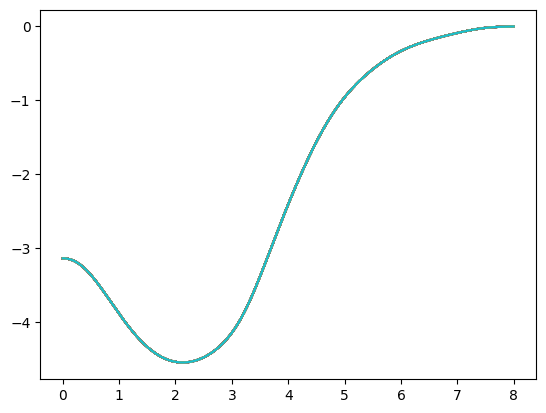

In [36]:
plt.figure()
for i in range(50):
    plt.plot(t, X_pred[:,i,0].detach().numpy())
plt.show()

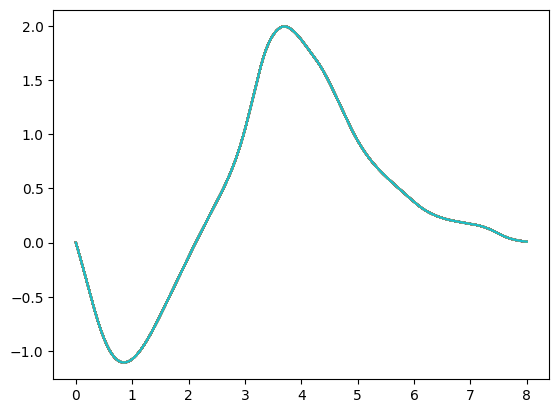

In [37]:
plt.figure()
for i in range(50):
    plt.plot(t, X_pred[:,i,1].detach().numpy())
plt.show()


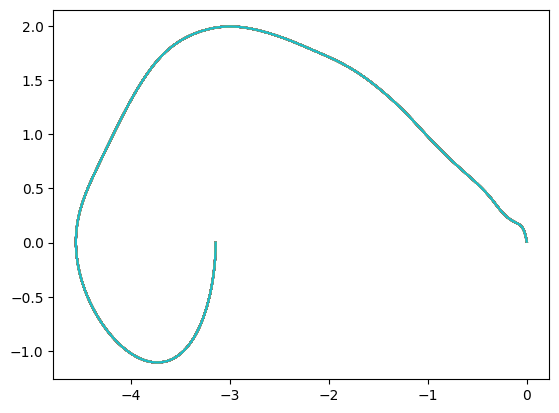

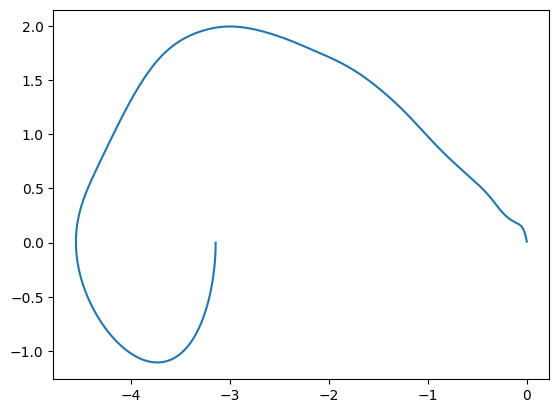

In [38]:
plt.figure()
for i in range(50):
    plt.plot(X_pred[:,i,0].detach().numpy(), X_pred[:,i,1].detach().numpy())
plt.show()

plt.figure()
plt.plot(X_pred[:,:,0].mean(axis=1).detach().numpy(), X_pred[:,:,1].mean(axis=1).detach().numpy())
plt.show()

In [25]:
# plt.figure()
# for i in range(3):
#     plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy())
# plt.show()

# plt.figure()
# plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy())
# plt.show()

In [26]:
# plt.figure()
# for i in range(3):
#     plt.plot(X_pred3[:,i,0].detach().numpy(), X_pred3[:,i,1].detach().numpy())
# plt.show()

# plt.figure()
# plt.plot(X_pred3[:,:,0].mean(axis=1).detach().numpy(), X_pred3[:,:,1].mean(axis=1).detach().numpy())
# plt.show()

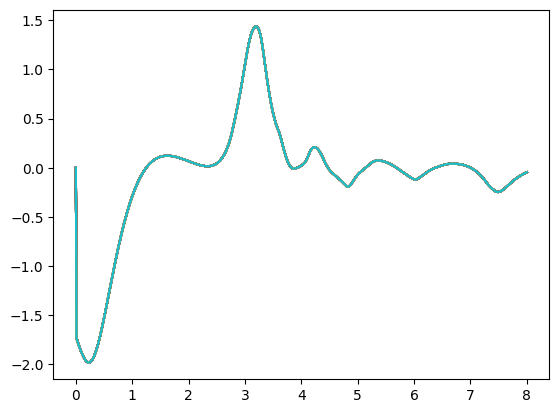

In [39]:
plt.figure()
for i in range(50):
    plt.plot(t, k_record[:,i,0].detach().numpy())
    # plt.plot(u_s_record[:,i,0].detach().numpy(), color='b')
plt.show()

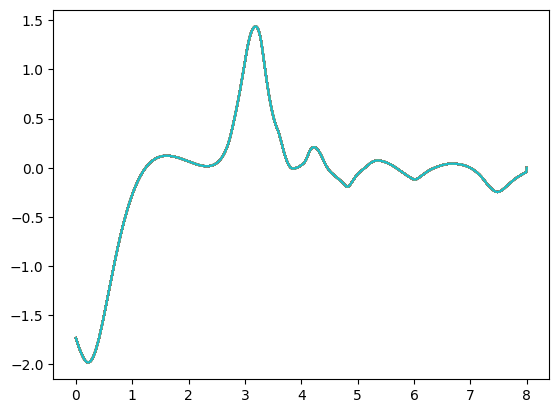

In [40]:
plt.figure()
for i in range(50):
    plt.plot(t, u1_record[:,i,0].detach().numpy())
    # plt.plot(u2_record[:99,i,0].detach().numpy(), color='b')
    # plt.plot(u3_record[:99,i,0].detach().numpy(), color='g')
plt.show()